<a href="https://colab.research.google.com/github/sarvnn/EVA4/blob/master/EVA4_assignment5_expt4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 5
# Experiment - 4

The targets to achieve in this assignment are as follows. 
Overall assignment targets
1. Achieve a test accuracy of 99.4% (consistently)
2. Less than or equal to 15 epochs
3. Less than 10000 parameters



In the first experiment, We have achieved less than 10000 parameters that can perform adequately (~99.3% test accuracy)
THe second experiment did not work out very well. 
The third experiment A learning rate scheduler was added and the target test accuracy of 99.4% was reached within Epoch - 10.

In this experiment, the target is to improve the accuracy and to achieve it more frequently and consistently by modifying the learning rate and by altering the parameters of a learning rate scheduler.

Targets: Modify the parameters of the learning rate scheduler to see its effect on Test accuracy.

Results: Best Training accuracy : 99.02%; Best Test accuracy : 99.34%% - EPOCH 10
Analysis: Modifying the initial learning rate to 0.05 and the gamma to 0.2 has helped us reach a better trining accuracy, however the target of 99.4%  test accuracy could not be achieved. More experiments on the learning rates can be done to see if the test accuracy 99.4% can be achieved more consistently. 


# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-5.0, 5.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [5]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


# Dataloader Arguments & Test/Train Dataloaders


In [6]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [7]:
import torch.nn.functional as F
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 26
        # self.convblock1a = nn.Sequential(
        #     nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
        #     nn.ReLU(),
        #     nn.BatchNorm2d(8),
        #     nn.Dropout(dropout_value)
        # ) # output_size = 26
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 13

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 11

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 9
        # self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 7
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 5
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 5
        # self.convblock7 = nn.Sequential(
        #     nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
        #     nn.ReLU(),            
        #     nn.BatchNorm2d(16),
        #     nn.Dropout(dropout_value)
        # ) # output_size = 5
        # self.convblock8 = nn.Sequential(
        #     nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
        #     nn.ReLU(),            
        #     nn.BatchNorm2d(16),
        #     nn.Dropout(dropout_value)
        # ) # output_size = 3
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=5)
        ) # output_size = 1

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        # x = self.convblock1a(x)
        x = self.pool1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        # x = self.convblock7(x)
        # x = self.convblock8(x)
        x = self.gap(x)        
        x = self.convblock9(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
         MaxPool2d-5           [-1, 16, 13, 13]               0
            Conv2d-6           [-1, 16, 11, 11]           2,304
              ReLU-7           [-1, 16, 11, 11]               0
       BatchNorm2d-8           [-1, 16, 11, 11]              32
           Dropout-9           [-1, 16, 11, 11]               0
           Conv2d-10           [-1, 16, 11, 11]             256
           Conv2d-11             [-1, 16, 9, 9]           2,304
             ReLU-12             [-1, 16, 9, 9]               0
      BatchNorm2d-13             [-1, 16, 9, 9]              32
          Dropout-14             [

# Less than 10000 parameters achieved by altering the network.


# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Modifying learning rate to see its effect on test accuracy


In [9]:
from torch.optim.lr_scheduler import StepLR

learning_rate = 0.05

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
scheduler = StepLR(optimizer, step_size=2, gamma=0.2)


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 1


Loss=0.09175709635019302 Batch_id=468 Accuracy=93.36: 100%|██████████| 469/469 [00:14<00:00, 31.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0482, Accuracy: 9842/10000 (98.42%)

EPOCH: 2


Loss=0.10662060976028442 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:14<00:00, 31.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0378, Accuracy: 9884/10000 (98.84%)

EPOCH: 3


Loss=0.05602770671248436 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:15<00:00, 30.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0397, Accuracy: 9871/10000 (98.71%)

EPOCH: 4


Loss=0.04418521746993065 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:15<00:00, 37.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0312, Accuracy: 9895/10000 (98.95%)

EPOCH: 5


Loss=0.026807555928826332 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:14<00:00, 32.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0308, Accuracy: 9912/10000 (99.12%)

EPOCH: 6


Loss=0.020143186673521996 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:14<00:00, 32.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Accuracy: 9916/10000 (99.16%)

EPOCH: 7


Loss=0.018323972821235657 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:15<00:00, 34.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0255, Accuracy: 9925/10000 (99.25%)

EPOCH: 8


Loss=0.07969609647989273 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:14<00:00, 32.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 9919/10000 (99.19%)

EPOCH: 9


Loss=0.045104384422302246 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:14<00:00, 33.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Accuracy: 9929/10000 (99.29%)

EPOCH: 10


Loss=0.03265394642949104 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:14<00:00, 31.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9930/10000 (99.30%)

EPOCH: 11


Loss=0.022553831338882446 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:14<00:00, 31.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9934/10000 (99.34%)

EPOCH: 12


Loss=0.007165094371885061 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:14<00:00, 32.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9933/10000 (99.33%)

EPOCH: 13


Loss=0.021648377180099487 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:14<00:00, 32.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9930/10000 (99.30%)

EPOCH: 14


Loss=0.020151281729340553 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:14<00:00, 31.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9931/10000 (99.31%)

EPOCH: 15


Loss=0.06756958365440369 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:14<00:00, 31.74it/s]



Test set: Average loss: 0.0186, Accuracy: 9933/10000 (99.33%)



# Let's Train and test our model

This time let's add a scheduler for out LR. 

Text(0.5, 1.0, 'Test Accuracy')

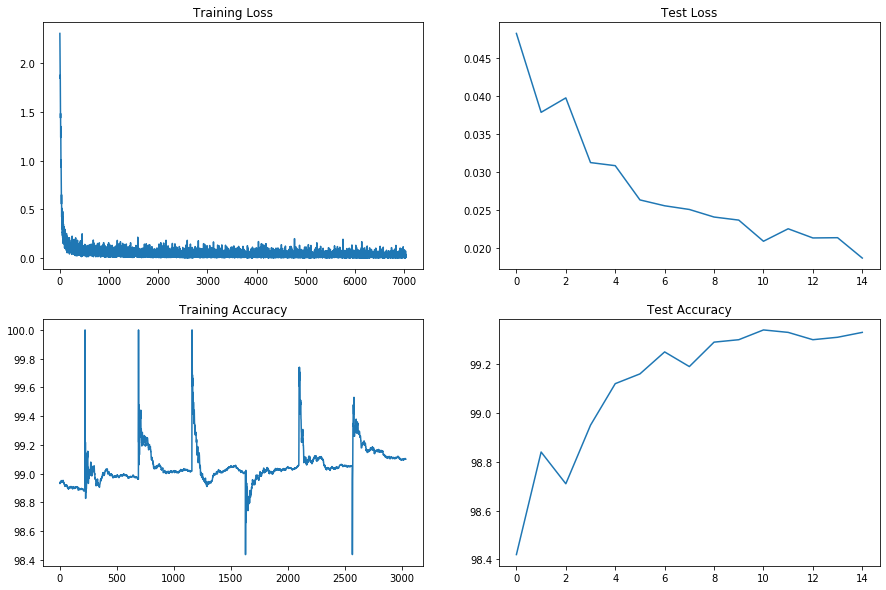

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")